In [1]:
import pandas as pd
import numpy as np

raw = pd.read_csv('datasets/mushrooms_dataset.csv', na_values = "['-']", encoding = 'utf-8')
df = raw.copy()

df.head()

,chut,hymenofor,jedla,jmeno,klobouk_barva,klobouk_povrch,klobouk_tvar,konzistence,latin,pochva,prsten,tren_barva,tren_povrch,tren_tvar,vune,vyskyt_doba,vyskyt_misto
0,['příjemná'],['lupeny'],['jedlá'],Bedla červenající,['hnědá'],['šupinkatý'],"['kulovitý, plochý, s\xa0hrbolkem, zvoncovitý,...",['dřevnatá'],(Macrolepiota rhacodes),['nemá'],['má'],"['bílá, okrová']",['hladký'],"['válcovitý, hlízovitý']",['příjemná'],"['červenec, srpen, září, říjen']","['jehličnatý les, listnatý les, smíšený les, z..."
1,NaN,['rourky'],['nejedlá'],Anýzovník vonný,"['hnědá, žlutá']","['hrbolkatý, jamkatý, plstnatý']","['polokulovitý, excentrický']",['dřevnatá'],(Gloeophyllum odoratum),NaN,NaN,NaN,NaN,NaN,"['anýzová, aromatická']","['leden, únor, březen, duben, květen, červen, ...","['jehličnatý les, smíšený les']"
2,['příjemná'],['lupeny'],['jedlá'],Bedla vysoká,['hnědá'],['šupinkatý'],"['kulovitý, plochý, zvoncovitý']",['dřevnatá'],(Macrolepiota procera),['nemá'],['má'],['hnědá'],NaN,"['válcovitý, hlízovitý']","['příjemná, houbová']","['červenec, srpen, září, říjen']","['jehličnatý les, listnatý les, smíšený les, p..."
3,"['příjemná, kořenitá, sladká']",['jiné'],['jedlá'],Bělolanýž obecný,NaN,NaN,NaN,['tvrdá'],(Choiromyces meandriformis),NaN,NaN,NaN,NaN,NaN,"['kořenitá, aromatická']","['červenec, srpen, září']","['jehličnatý les, listnatý les, smíšený les']"
4,['hořká'],['rourky'],['nejedlá'],Březovník obecný,"['bílá, okrová']",['hladký'],['polokulovitý'],['měkká'],(Piptoporus betulinus),NaN,NaN,NaN,NaN,NaN,NaN,"['květen, červen, červenec, srpen, září, říjen']","['listnatý les, smíšený les, parky']"


# CLEAN DATA

In [2]:
# define function to get rid of ['']

def delist(value):
    if value is not np.nan:
        value = value[2:-2]
        return value
    else:
        return value

# clean columns of parentheses
df['latin'] = df['latin'].str.replace(r'[()]', '')

# define columns that are not surroundedby [''] and drop them
cols_name = ['jmeno', 'latin']
cols_start = df[cols_name]
df = df.drop(columns = cols_name)

#apply function to rest
df = df.applymap(delist)

# change binary to 0 or 1
df['pochva'] = df['pochva'].map({'má': 1, 'nemá': 0}).fillna(0)
df['prsten'] = df['prsten'].map({'má': 1, 'nemá': 0}).fillna(0)

# clean lupeny
df['hymenofor'] = df['hymenofor'].replace('jiné', 'nema')

In [3]:
# cols with values that need to be filled
cols_fill = ['klobouk_barva', 'klobouk_povrch', 'klobouk_tvar', 'konzistence', 'tren_barva', 
             'tren_povrch', 'tren_tvar', 'vune', 'hymenofor']

# loop through and fill NA with "does not have"
for column in df[cols_fill]:
    df[column] = df[column].fillna('nema')

In [4]:
# clean column
def clean_unicode(value):
    return value.replace('\\xa0', ' ')

df['klobouk_tvar'] = df[['klobouk_tvar']].applymap(clean_unicode)

In [5]:
# join dataframes again
df = df.merge(cols_start, right_index = True, left_index = True, how = 'outer')

# create column of species
df['rod'] = df['latin'].str.extract(r'(\w*)(?:\w*)')

# drop some cols
cols_to_drop = ['chut']
df.drop(columns = cols_to_drop, inplace = True)

# set index
df.set_index('jmeno', inplace = True)

In [6]:
# binarize edible column - jedla = 1, else 0

df['jedla'] = df['jedla'].where(df['jedla'] == 'jedlá', 0).replace('jedlá', 1)

# PLOT GENUS

In [7]:
# only include genus with at least 3 mushrooms
threshold = 2

# create new df
df_lowOccurences = df.copy()

# remove low value genuses
value_counts = df_lowOccurences.stack().value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
df_lowOccurences.replace(to_remove, np.nan, inplace = True)
df_lowOccurences.dropna(subset = ['rod'], inplace = True)

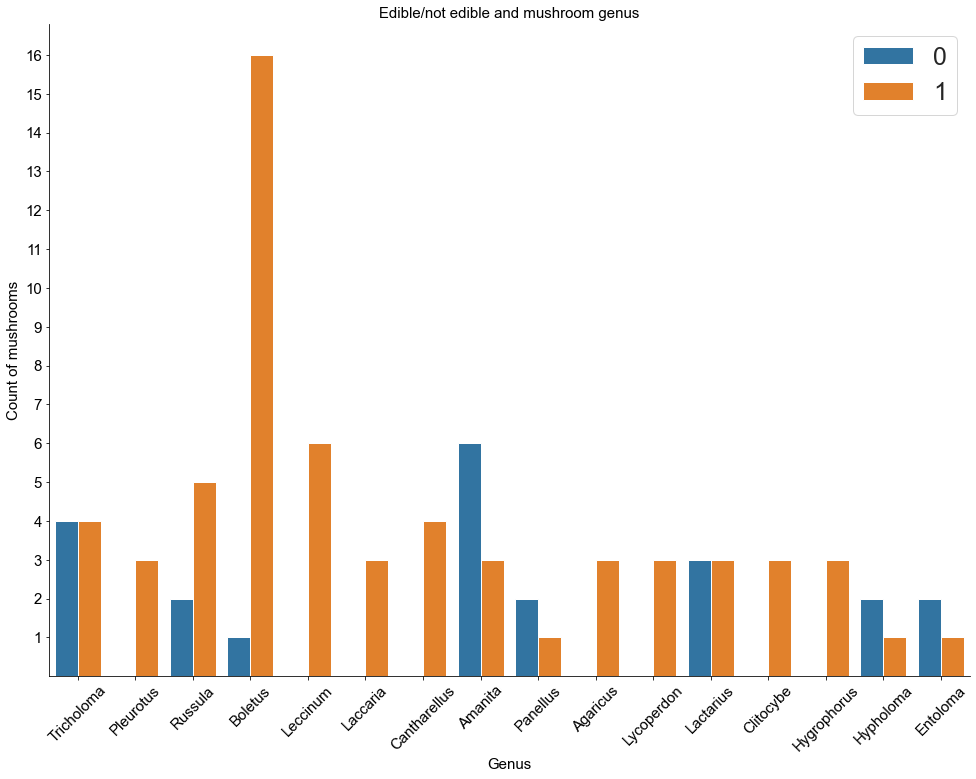

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

size = (16.5, 12)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
sns.countplot(x="rod", hue="jedla", data=df_lowOccurences)
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Genus', fontsize = 15)
ax.set_ylabel('Count of mushrooms', fontsize = 15)
ax.set_title('Edible/not edible and mushroom genus', fontsize = 15)
plt.legend(prop={'size': 25})
ax.set_yticks(list(range(1,17)));

# PLOT HYMENOFOR

In [9]:
#define function
def get_first(value):
    value = value.split(',')[0]
    return value

#apply
df_hymenofor = df.copy()
df_hymenofor[cols_fill] = df_hymenofor[cols_fill].applymap(get_first)

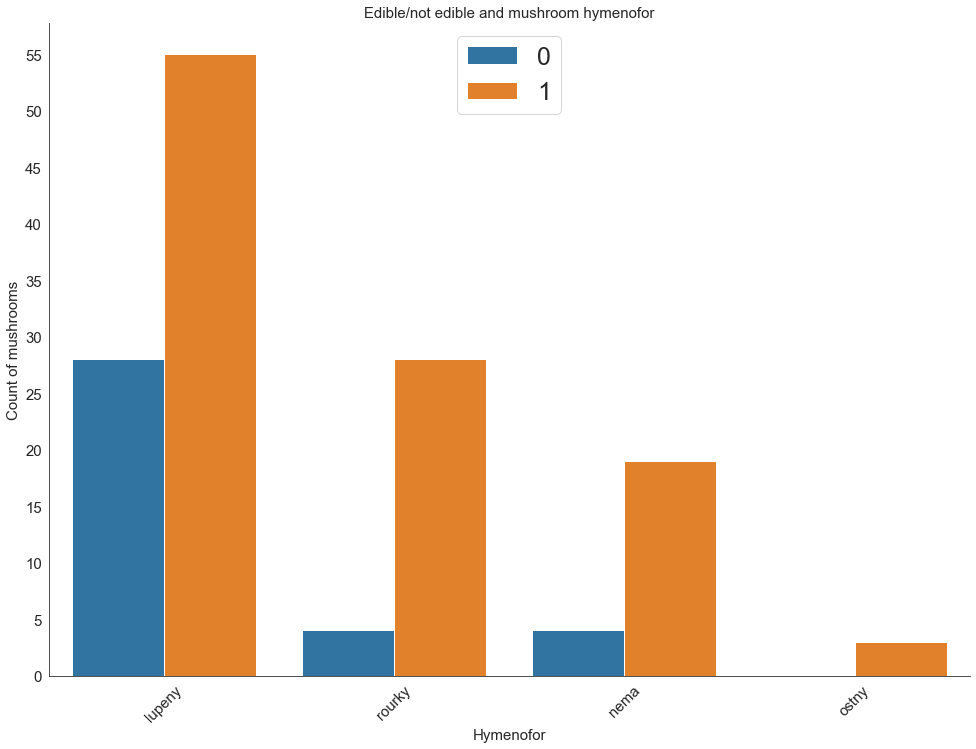

In [10]:
size = (16.5, 12)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
sns.countplot(x="hymenofor", hue="jedla", data=df_hymenofor)
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Hymenofor', fontsize = 15)
ax.set_ylabel('Count of mushrooms', fontsize = 15)
ax.set_title('Edible/not edible and mushroom hymenofor', fontsize = 15)
plt.legend(prop={'size': 25})
ax.set_yticks(list(range(0,60, 5)));

# PLOT MONTH

In [11]:
def to_list(value):
    list_of_vals = value.split(', ')
    return list_of_vals

df['vyskyt_doba'] = df[['vyskyt_doba']].applymap(to_list)
df['vyskyt_misto'] = df[['vyskyt_misto']].applymap(to_list)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

col_to_binarize1 = df['vyskyt_doba']
col_to_binarize2 = df['vyskyt_misto']

mlb = MultiLabelBinarizer()

df_months_binarized = pd.DataFrame(mlb.fit_transform(col_to_binarize1), columns = mlb.classes_, index = df.index)
df_places_binarized = pd.DataFrame(mlb.fit_transform(col_to_binarize2), columns = mlb.classes_, index = df.index)

In [13]:
# drop columns
df = df.drop(columns = ['vyskyt_doba', 'vyskyt_misto'])

# merge with binarized columns
df = df.merge(df_months_binarized, right_index = True, left_index = True, how = 'left')
df = df.merge(df_places_binarized, right_index = True, left_index = True, how = 'left')

In [14]:
months_cz = ['leden', 'únor', 'březen', 'duben', 'květen', 'červen', 
             'červenec', 'srpen', 'září', 'říjen', 'listopad', 'prosinec']

month_freq = pd.DataFrame(df[months_cz].apply(sum, axis = 0), columns = ['month'])
month_freq['month'] = month_freq['month'].astype(int)

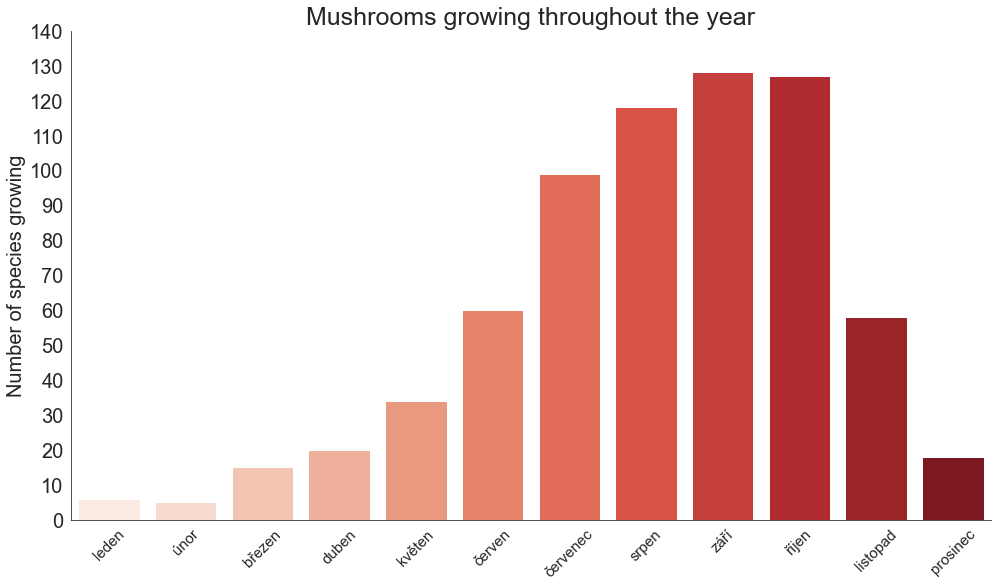

In [15]:
size = (16.5, 9)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
ax = sns.barplot(y="month", x=month_freq.index, data=month_freq, palette = 'Reds')
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 20)
ax.set_ylabel('Number of species growing', fontsize = 20)
ax.set_title('Mushrooms growing throughout the year', fontsize = 25)
ax.set_yticks(list(range(0,150, 10)));

# PLOT PLACE

In [16]:
places = ['jehličnatý les', 'kosodřevina', 'křoviny',
       'listnatý les', 'louky', 'mýtiny', 'parky', 'paseky', 'pastviny',
       'pole', 'rašeliniště', 'sady', 'smíšený les', 'stráně', 'zahrady']

places_freq = pd.DataFrame(df[places].apply(sum, axis = 0), columns = ['place'])
places_freq['place'] = places_freq['place'].astype(int)
places_freq = pd.DataFrame(places_freq['place'].sort_values(ascending = False))

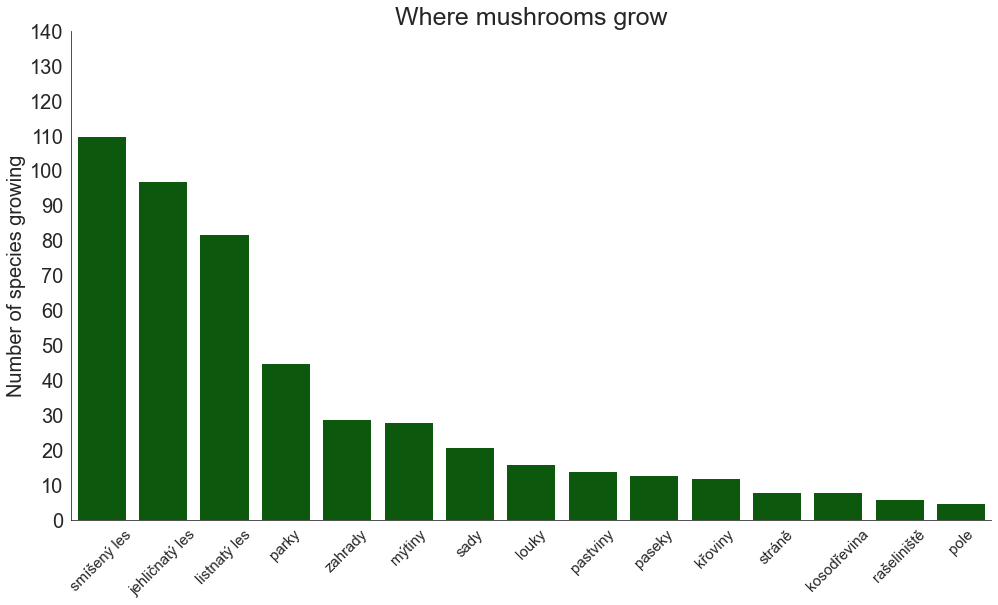

In [17]:
size = (16.5, 9)
fig, ax = plt.subplots(figsize=size)

sns.set_style('white')
ax = sns.barplot(y="place", x=places_freq.index, data=places_freq, color = '#006400')
sns.despine()
plt.xticks(rotation= 45, fontsize = 15)
plt.yticks(fontsize = 20)
ax.set_ylabel('Number of species growing', fontsize = 20)
ax.set_title('Where mushrooms grow', fontsize = 25)
ax.set_yticks(list(range(0,150, 10)));

# PLOT OTHER CHARACTERISTICS

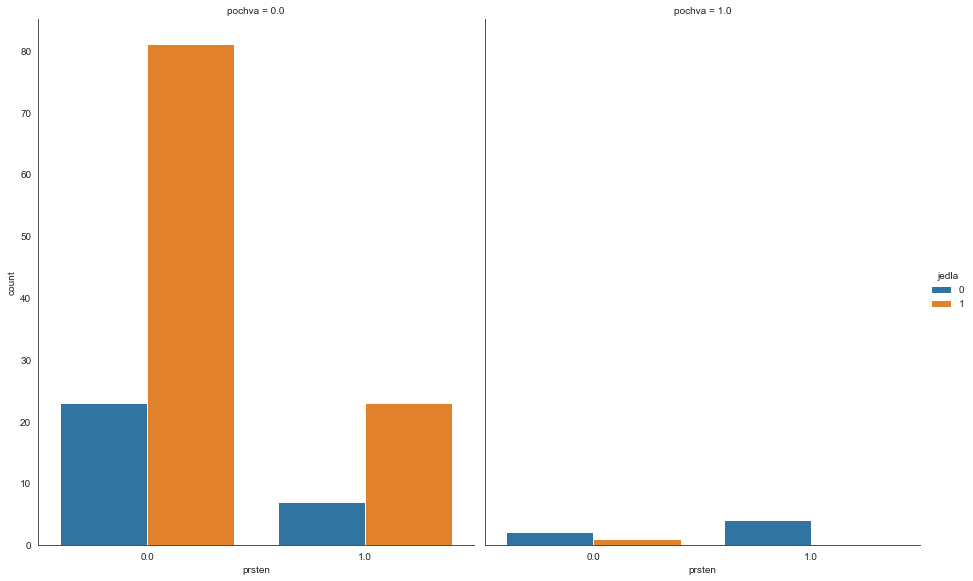

In [18]:
g = sns.catplot(x="prsten", hue="jedla", col="pochva",
                data=df, kind="count",
                height=8, aspect=0.8);

# Predictive modelling

In [19]:
# create copy of original df 
df_glm = df.copy()

In [20]:
# which cols to binarize & one hot encode
cols_to_binarize = ['klobouk_barva', 'klobouk_povrch', 'klobouk_tvar',
                    'konzistence', 'tren_barva', 'tren_povrch', 'tren_tvar'] 

# drop useless columns - smell, places and months
df_glm = df_glm.drop(columns = ['vune'])
df_glm = df_glm.drop(columns = months_cz)
df_glm = df_glm.drop(columns = places)

# convert all columns to list
df_glm[cols_to_binarize] = df_glm[cols_to_binarize].applymap(to_list)

## Data preprocessing

In [21]:
# simply create series for each variable for further processing
col2bin1 = df_glm['klobouk_barva']
col2bin2 = df_glm['klobouk_povrch']
col2bin3 = df_glm['klobouk_tvar']
col2bin4 = df_glm['konzistence']
col2bin5 = df_glm['tren_barva']
col2bin6 = df_glm['tren_povrch']
col2bin7 = df_glm['tren_tvar']

In [22]:
# columns always include more categories in one cell - first, these need to be split into separate columns, and then
# transformed (+ added suffix for identification)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# create column out of each value of each column & binarize
bin1 = pd.DataFrame(mlb.fit_transform(col2bin1), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_b')
bin2 = pd.DataFrame(mlb.fit_transform(col2bin2), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_p')
bin3 = pd.DataFrame(mlb.fit_transform(col2bin3), columns = mlb.classes_, index = df_glm.index).add_suffix('_klobouk_t')
bin4 = pd.DataFrame(mlb.fit_transform(col2bin4), columns = mlb.classes_, index = df_glm.index).add_suffix('_konzistence')
bin5 = pd.DataFrame(mlb.fit_transform(col2bin5), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_b')
bin6 = pd.DataFrame(mlb.fit_transform(col2bin6), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_p')
bin7 = pd.DataFrame(mlb.fit_transform(col2bin7), columns = mlb.classes_, index = df_glm.index).add_suffix('_tren_t')

In [23]:
# drop columns
df_glm = df_glm.drop(columns = cols_to_binarize)

# merge with binarized columns
df_glm = df_glm.merge(bin1, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin2, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin3, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin4, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin5, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin6, right_index = True, left_index = True, how = 'left')
df_glm = df_glm.merge(bin7, right_index = True, left_index = True, how = 'left')


In [24]:
from sklearn.preprocessing import OneHotEncoder

# which cols to drop - aren't useful features 
# i.e. you're not gonna identify a mushroom you find in a forest by name
cols_not_features = ['latin', 'rod', 'jiné']
features = df_glm.loc[:,~df_glm.columns.isin(cols_not_features)]

# one hot encode one variable (hymenofor)
enc = OneHotEncoder()
hymenofor_enc = enc.fit_transform(features[['hymenofor']])
hymenofor_enc = pd.DataFrame(hymenofor_enc.toarray(), columns = enc.categories_)

# create final df
features = features.drop(columns = ['hymenofor'])
hymenofor_enc = hymenofor_enc.set_index(df_glm.index)
features = pd.concat([features, hymenofor_enc], axis=1)

### Collinearity

In [25]:
# let's see if there are any collinear relationships with a useful stats package pengouin

import pingouin as pg
features_cor = pg.pairwise_corr(features, method='pearson')

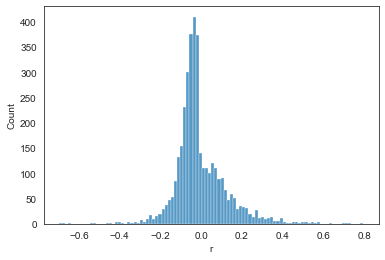

In [26]:
# see distribution

sns.histplot(data=features_cor, x="r");

Obviously there are a few features that are heavily correlated and need attention. With highly correlated features, model performance can decrease (especially models like LogReg)

In [27]:
# here we can see most correlated features. It is no suprise - thorn color is correlated with cap color.
# also, not having a thorn is correlated negatively with having a color or shape of thorn.
# what is interesting is that a mushroom with bumpy cap is positively correlated with having a perforated one.

features_cor[(features_cor['r'].gt(0.6) | features_cor['r'].lt(-0.6))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
384,fialová_klobouk_b,fialová_tren_b,pearson,two-sided,141,0.781801,"[0.71, 0.84]",0.611213,0.605579,1.049987,2.627632e-30,1.368e+27,1.0
1011,zelená_klobouk_b,zelená_tren_b,pearson,two-sided,141,0.634960,"[0.52, 0.72]",0.403175,0.394525,0.749684,2.778719e-17,2.414e+14,1.0
1326,hrbolkatý_klobouk_p,jamkatý_klobouk_p,pearson,two-sided,141,0.719033,"[0.63, 0.79]",0.517008,0.510008,0.905639,1.009032e-23,4.786e+20,1.0
2270,nema_klobouk_t,nema_konzistence,pearson,two-sided,141,0.699379,"[0.6, 0.78]",0.489130,0.481727,0.866083,5.120660e-22,1.024e+19,1.0
3195,nema_tren_b,nema_tren_p,pearson,two-sided,141,0.638416,"[0.53, 0.73]",0.407575,0.398989,0.755496,1.652679e-17,4.008e+14,1.0
3206,nema_tren_b,nema_tren_t,pearson,two-sided,141,0.795904,"[0.73, 0.85]",0.633464,0.628152,1.087338,4.296817e-32,7.753e+28,1.0
3208,nema_tren_b,válcovitý_tren_t,pearson,two-sided,141,-0.670238,"[-0.75, -0.57]",0.449219,0.441236,-0.811175,9.948886e-20,5.913e+16,1.0
3262,olivová_tren_b,tečkovaný_tren_p,pearson,two-sided,141,0.704577,"[0.61, 0.78]",0.496429,0.489130,0.876332,1.870240e-22,2.744e+19,1.0
3644,síťkovaný_tren_p,soudkovitý_tren_t,pearson,two-sided,141,0.728821,"[0.64, 0.8]",0.531180,0.524386,0.926208,1.256836e-24,3.682e+21,1.0
3721,nema_tren_t,válcovitý_tren_t,pearson,two-sided,141,-0.698272,"[-0.77, -0.6]",0.487583,0.480157,-0.863920,6.327995e-22,8.322e+18,1.0


In [28]:
# create X and y (target variable and features)
y = features.pop('jedla')
X = features

# see frequencies of each variable
features_freq = features.apply(sum, axis = 0).sort_values()
features_freq

prohloubený_klobouk_t      1.0
tečkovaný_tren_p           1.0
chlupatý_tren_p            1.0
ojíněný_tren_p             1.0
olivová_tren_b             2.0
                         ...  
hnědá_klobouk_b           73.0
klenutý_klobouk_t         75.0
(lupeny,)                 83.0
plochý_klobouk_t          94.0
válcovitý_tren_t         115.0
Length: 86, dtype: float64

Let's use a method to remove non-informative features or correlated features (as seen above) because it improves classification power. I have done this using the **RFE (recursive feature elimination)**, which removes a single feature each iteration and compares the model. I have set it to remove half of the features to reduce the number, but this can be set to an arbitrary number.

### Split into train, test and validation datasets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, stratify = y_train)

In [30]:
print(len(X_train), len(X_test), len(y_train), len(y_test), len(X_val), len(y_val))

print('Train set:     ', np.unique(y_train, return_counts = True))
print('Validation set:', np.unique(y_val, return_counts = True))
print('Test set:      ', np.unique(y_test, return_counts = True))

89 29 89 29 23 23
Train set:      (array([0, 1], dtype=int64), array([23, 66], dtype=int64))
Validation set: (array([0, 1], dtype=int64), array([ 6, 17], dtype=int64))
Test set:       (array([0, 1], dtype=int64), array([ 7, 22], dtype=int64))


## MachineLearning models tryout

In [31]:
# set up GLM, random forest, SVC, MLP and NB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


glm_clf = LogisticRegression(random_state = 1, class_weight = 'balanced')
rfc_clf = RandomForestClassifier(random_state=42, class_weight = 'balanced')
svc_clf = SVC(random_state=42, class_weight = 'balanced')
gnb_clf = GaussianNB()

In [32]:
# train each estimator and evaluate using f1 score, because it is an appropriate metric here
# - maximalizing both precision and recall is better than focusing on e.g. accuracy alone
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict

estimators = [glm_clf, rfc_clf, svc_clf]
for index, estimator in enumerate(estimators):
    if type(estimator).__name__ == 'SVC':
        y_pred = cross_val_predict(estimator, X_train, y_train, cv = 3)
        print("Training estimator", type(estimator).__name__)
        print('f1 score:', round(f1_score(y_pred, y_train),3), '\n')
    else:
        rfe = RFECV(estimator=estimator)
        pipeline = Pipeline(steps=[('rfe', rfe),('est', estimator)])
        print("Training estimator", type(estimator).__name__)
        y_pred = cross_val_predict(pipeline, X_train, y_train, cv = 3)
        print('f1 score:', round(f1_score(y_pred, y_train),3), '\n')
    

Training estimator LogisticRegression
f1 score: 0.8 

Training estimator RandomForestClassifier
f1 score: 0.844 

Training estimator SVC
f1 score: 0.803 



In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# Crossvalidation - try to validate models also using a stratified KFold technieque 
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 1)

for index, estimator in enumerate(estimators):
    scores = cross_val_score(estimator.fit(X_train, y_train), X_train, y_train, scoring = 'f1', cv = cv)
    print('Mean f1 for estimator',type(estimator).__name__,': %.3f' % np.mean(scores))

Mean f1 for estimator LogisticRegression : 0.798
Mean f1 for estimator RandomForestClassifier : 0.854
Mean f1 for estimator SVC : 0.802


It seems like the best model with the highest f1 score is the RFC, SVC and GLM. We can easily discard NB classifier. Let's explore further.

### Performance on validation dataset for chosen models

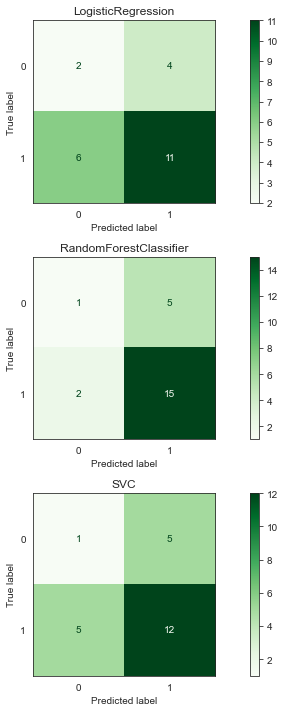

In [34]:
from sklearn.metrics import plot_confusion_matrix

estimators = [glm_clf, rfc_clf, svc_clf]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))

for cls, ax in zip(estimators, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_val, 
                          y_val, 
                          ax=ax, 
                          cmap='Greens')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  

It seems like the RFC algorithm has simply learned to classify most labels as 1 - that is not ideal, we want to avoid mushrooms that are poisonous at the cost of evaluating edible ones as inedible, rather than the other way around.

From the rest, all models preform almost equally, but I want the least FP due to the nature of the problem. I will use SVC as a classifier further.

### Finding best hyper parameters - Tuning Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# choose parameter differences

param_grid = [{'est__penalty': ['l1', 'l2'], 
               'est__C': [0.2, 0.5, 1, 2, 4],
               'est__solver': ['liblinear'],
               'poly__degree': [2, 3]},
             {'est__penalty': ['elasticnet'],
              'est__C': [0.2, 0.5, 1, 2, 4],
              'est__solver': ['saga'],
              'poly__degree': [2, 3],
              'est__l1_ratio': [0.25, 0.5, 0.75]}] 

# fit a new model!

glm_2 = LogisticRegression(random_state = 1, class_weight = 'balanced', max_iter = 1000)
#rfe = RFECV(estimator=glm_2)
poly = PolynomialFeatures()
pipe = Pipeline(steps=[('poly', poly),('est', glm_2)])

grid_search_glm = GridSearchCV(pipe, param_grid, cv=cv,
                           scoring= 'f1',
                           return_train_score=True)

# search
grid_search_glm.fit(X_train, y_train);

C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was re

In [ ]:
# see best parameters to maximize f1 score on training set.

print(grid_search_glm.best_params_)

#### Fit with new hyperparameters

In [ ]:
# fit final model

glm_final = grid_search_glm.best_estimator_

scores = cross_val_score(glm_final, X_train, y_train, scoring = 'f1', cv = cv)
print('Mean f1: %.3f' % np.mean(scores))

We have slightly improved performance. Let's see confusion matrix.

In [ ]:
# create function for confusion matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap = 'Greens')
  plt.title('Confusion matrix at probability: {:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Mushroom detected as inedible (True Negatives): ', cm[0][0])
  print('Mushroom incorrectly predicted as edible (False Positives): ', cm[0][1])
  print('Mushroom incorrectly predicted as inedible (False Negatives): ', cm[1][0])
  print('Mushroom detected as edible (True Positives): ', cm[1][1])
  print('Total edible mushrooms: ', np.sum(cm[1]))

In [ ]:
# Since our model outputs probabilities, we can play with the threshold and therefore modify the desired amount of FP.

y_pred_final_glm = glm_final.predict(X_val)
y_probs_final_glm = glm_final.predict_proba(X_val)
probs_edible_final = y_probs_final_glm[:,1:2]

plot_cm(y_val, probs_edible_final, p = 0.5)

**It seems that the model is not very good, but keep in mind that we want as little FP as possible. Due to the model classifying certain mushrooms as close to 1 (probability of being edible approaches 1, such as 0.999) this is as good as we can get. If we set the probability higher, we reach not much better results.**

### Finding best hyper parameters - Tuning SVC

In [54]:
from sklearn.model_selection import GridSearchCV

# choose parameter differences

param_grid = [{'kernel': ['poly'], 
               'C': [0.3, 0.5, 1, 2, 5, 7, 10],
               'coef0': [0.0, 0.1, 0.2, 0.3],
               'degree': [2, 3]}]
         
              
# fit a new model!
svc_2 = SVC(random_state = 42, class_weight = 'balanced', max_iter = 1000)
grid_search_svc = GridSearchCV(svc_2, param_grid, cv=cv,
                           scoring= 'f1',
                           return_train_score=True)

# search
grid_search_svc.fit(X_train, y_train);

In [55]:
# see best parameters to maximize f1 score on training set.

print(grid_search_svc.best_params_)

{'C': 5, 'coef0': 0.3, 'degree': 3, 'kernel': 'poly'}


In [56]:
# fit final model

svc_final = grid_search_svc.best_estimator_

scores_svc = cross_val_score(svc_final, X_train, y_train, scoring = 'f1', cv = cv)
print('Mean f1: %.3f' % np.mean(scores_svc))

Mean f1: 0.848


Mushroom detected as inedible (True Negatives):  1
Mushroom incorrectly predicted as edible (False Positives):  5
Mushroom incorrectly predicted as inedible (False Negatives):  4
Mushroom detected as edible (True Positives):  13
Total edible mushrooms:  17


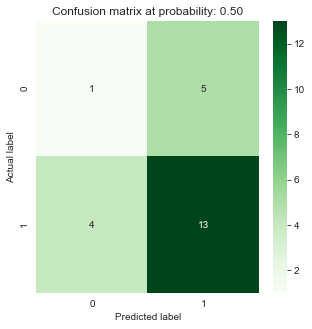

In [57]:
y_pred_final_svc = svc_final.predict(X_val)

plot_cm(y_val, y_pred_final_svc)

### Feature importance - which features best predict toxicity?

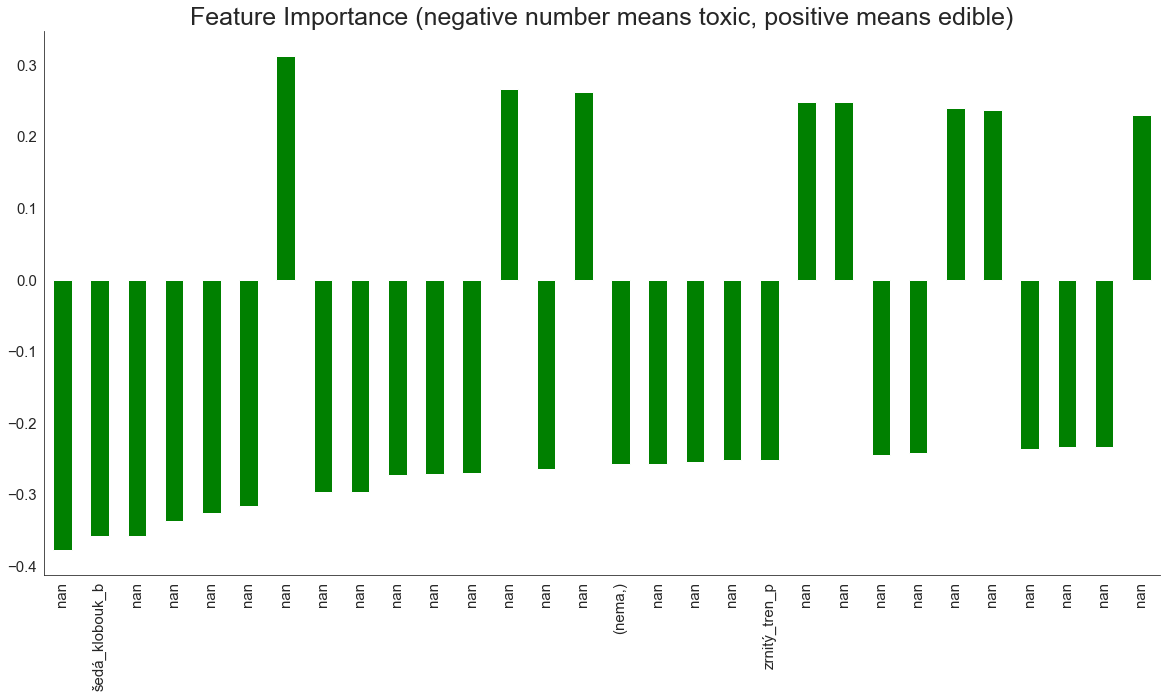

In [45]:
# create data frame of all coefficients, put to dataframe
coef_glm = pd.DataFrame(glm_final.named_steps['est'].coef_).T.rename(columns = {0: 'Importances'})
#coef_glm = pd.DataFrame(glm_final.coef_).T.rename(columns = {0: 'Importances'})
cols = pd.DataFrame(features.columns)

# add names of variables
coef_glm['Variables'] = cols

# sort descending, set index
coef_glm = coef_glm.iloc[(-coef_glm['Importances'].abs()).argsort()][:30]

# create plot
axs = coef_glm.plot.bar(y = 'Importances', x = 'Variables', color = 'g', figsize = (20,10), legend = False, fontsize = 15)
sns.despine()
axs.set_xlabel('')
axs.set_title('Feature Importance (negative number means toxic, positive means edible)', fontsize = 25);

### Evaluate logistic regression on final test set

Mushroom detected as inedible (True Negatives):  1
Mushroom incorrectly predicted as edible (False Positives):  6
Mushroom incorrectly predicted as inedible (False Negatives):  4
Mushroom detected as edible (True Positives):  18
Total edible mushrooms:  22
f1: 0.783


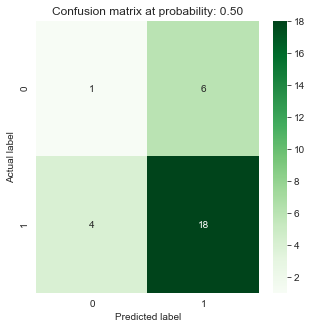

In [46]:
y_pred_final_test_glm = glm_final.predict(X_test)
y_probs_final_test_glm = glm_final.predict_proba(X_test)
probs_edible_final_test = y_probs_final_test_glm[:,1:2]

plot_cm(y_test, probs_edible_final_test, p = 0.5)
print('f1: %.3f' % f1_score(y_pred_final_test_glm, y_test))

### Evaluate SVM on final test set

Mushroom detected as inedible (True Negatives):  0
Mushroom incorrectly predicted as edible (False Positives):  7
Mushroom incorrectly predicted as inedible (False Negatives):  0
Mushroom detected as edible (True Positives):  22
Total edible mushrooms:  22
f1: 0.863


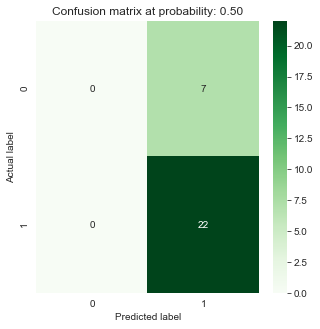

In [47]:
y_pred_final_test_svc = svc_final.predict(X_test)

plot_cm(y_test, y_pred_final_test_svc)
print('f1: %.3f' % f1_score(y_pred_final_test_svc, y_test))

Below we can see the 4 misclassified mushrooms. 

It is not so surprising that two "holubinka" were classified as edible, due to the fact that most "holubinka" mushroom _are_ edible and look fairly similar to other edible mushrooms. 

Same goes for "hadovka", which looks like a regular mushroom and may have therefore been classified as edible. 

As for Anýzovník, note that it is the only mushroom that has "rourky" hymenofor out of these 4 - which is usually a sign of edible! Only 4 mushrooms out of 32 that have this hymenofor are inedible.

In [48]:
finalpreds = X_test.copy()

finalpreds['predicted'] = probs_edible_final_test
finalpreds['label'] = y_test

finalpreds[(finalpreds['predicted'].gt(0.5) & finalpreds['label'].eq(0))]

,pochva,prsten,bílá_klobouk_b,fialová_klobouk_b,hnědá_klobouk_b,modrá_klobouk_b,nema_klobouk_b,okrová_klobouk_b,olivová_klobouk_b,oranžová_klobouk_b,...,nahoru ztenčující_tren_t,nema_tren_t,soudkovitý_tren_t,válcovitý_tren_t,"(lupeny,)","(nema,)","(ostny,)","(rourky,)",predicted,label
jmeno,,,,,,,,,,,,,,,,,,,,,
Holubinka smrdutá,0.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.984867,0
Květnatec Archerův,1.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.0,1.0,0.0,0.0,0.834031,0
Hadovka smrdutá,1.0,0.0,0,0,0,0,0,0,1,0,...,1,0,0,1,0.0,1.0,0.0,0.0,0.918327,0
Čirůvka kravská,0.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.619185,0
Anýzovník vonný,0.0,0.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0.0,0.0,0.0,1.0,0.815040,0
Holubinka vrhavka,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.955497,0


<AxesSubplot:xlabel='label'>

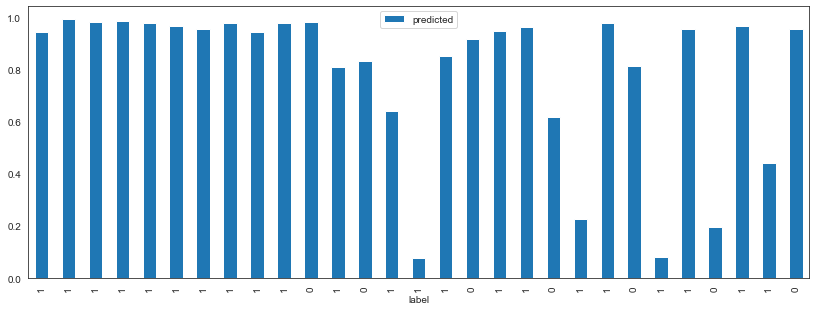

In [49]:
finalpreds.plot.bar(y= 'predicted', x = 'label', figsize = (14, 5))